# Milestone 2

<b>Zach Simms<b>

This milestone is meant to compare the observed track of Hurricane Ian to the GFS and GEFS forecast models to see which one was closest to the actual track. This is done by plotting minimum sea level pressure of all tracks, all tracks as it made landfall in Florida, and predicted wind speeds and intensities. 

NOAA Best Track Data: https://noaa.hub.arcgis.com/datasets/20d971f4472e4037af0f260f6454e7ab/about?layer=1

Imported GFS and GEFS Data via Herbie

## Step 1

Import necessary modules and read in the observed Hurricane Ian track data via pandas. Then, convert the observed track date column to datetime and sort the latitude, longitude, intensity, and MSLP columns into respective lists.

In [22]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import datetime as dt
from herbie import Herbie
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load observed hurricane track data
observed_track = pd.read_csv("/home/zas5258/meteo473/ianpreliminarytrack.csv")
obs_times = pd.to_datetime(observed_track['DTG'].astype(str), format='%Y%m%d%H')
obs_lats = observed_track['LAT']
obs_lons = observed_track['LON']
obs_slp = observed_track['MSLP']
obs_intensity = observed_track['INTENSITY'] 

## Step 2

This step is extracting and choosing proper run dates for the GFS forecast of Hurricane Ian. It creates a CSV file to use for data analysis and plotting. It also includes code to handle for errors that may arise when reading in the data through Herbie.

In [23]:
# Define Florida's latitude and longitude bounds
florida_bounds = {
    'lat_min': 24.396308,
    'lat_max': 31.000968,
    'lon_min': -87.634938,
    'lon_max': -79.974307
}

# Convert Florida's longitude bounds to [0, 360] since GFS uses this range
florida_bounds['lon_min'] += 360
florida_bounds['lon_max'] += 360

# Define the forecast model run time and initialize Herbie
forecast_run_date = dt.datetime(2022, 9, 27, 0)
H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=6) 

# Download GRIB2 file explicitly
try:
    H.download()
    print("GRIB2 file downloaded successfully.")
except Exception as e:
    print(f"Error downloading GRIB2 file: {e}")

# Load data using Herbie's xarray method and handle multiple hypercubes
try:
    # Load the dataset for the selected variable
    datasets = H.xarray("TMP:2 m")

    # Handle multiple hypercubes if returned
    if isinstance(datasets, list):
        ds = datasets[0]
    else:
        ds = datasets

    # Adjust longitudes to [-180, 180] for compatibility with Florida's bounds
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

    # Subset data for Florida's latitude and longitude bounds
    ds_fl = ds.sel(
        latitude=slice(florida_bounds['lat_max'], florida_bounds['lat_min']),
        longitude=slice(florida_bounds['lon_min'] - 360, florida_bounds['lon_max'] - 360)
    )

    # Check if subset is empty
    if ds_fl['t2m'].size == 0:
        print("No data found within Florida's bounds.")
    else:
        # Convert subsetted dataset to a Pandas DataFrame
        df_gfs = ds_fl.to_dataframe().reset_index()

        # Save DataFrame to CSV
        output_csv_path = "/home/zas5258/meteo473/gfs_forecast_florida.csv"
        df_gfs.to_csv(output_csv_path, index=False)
        print(f"Forecast data saved to CSV at {output_csv_path}")

except FileNotFoundError as e:
    print(f"File not found: {e}")
except KeyError as e:
    print(f"Variable not found in GRIB2 file: {e}")
except Exception as e:
    print(f"Error processing GFS data: {e}")


✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-27 00:00 UTC F06 ┊ GRIB2 @ local ┊ IDX @ aws
GRIB2 file downloaded successfully.
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
Error processing GFS data: [Errno 122] Disk quota exceeded


## Step 3

This step is loading in the GFS data, formatting the data's longitude and latitude data so that it can be properly used to map data for the hurricane, while also extracting the longitude and latitudes into their respective lists for plotting.

In [24]:
# Load forecast data from CSV
forecast_data = pd.read_csv("/home/zas5258/meteo473/gfs_forecast_florida.csv")

forecast_data['longitude'] = ((forecast_data['longitude'] + 180) % 360) - 180

# Extract latitude and longitude for plotting
forecast_lats = forecast_data['latitude']
forecast_lons = forecast_data['longitude']

## Step 4

This step does the following: 
1. Defines the geographic boundaries of Florida using latitude and longitude.
2. Sets the initialization time for the GFS weather model forecast.
3. Loops through a series of forecast hours (from 102 to 174, every 6 hours).
4. For each forecast hour:
5. Downloads the corresponding GFS data file.
6. Loads the mean sea-level pressure (PRMSL) field.
7. Adjusts longitudes to match the standard coordinate system.
8. Extracts the data specifically over Florida.
9. Finds the point of lowest pressure (potential storm center) within that region.
10. Saves the storm's latitude, longitude, pressure, and forecast time to a list.
11. Converts the list of storm positions into a Pandas DataFrame, which can be used for plotting or further analysis.

In [25]:
# Define Florida's latitude and longitude bounds (in -180 to 180 range)
florida_bounds = {
    'lat_min': 24.396308,
    'lat_max': 31.000968,
    'lon_min': -87.634938,
    'lon_max': -79.974307
}

# Forecast initialization date
forecast_run_date = dt.datetime(2022, 9, 23, 0)

# List to store GFS storm center data
storm_points = []

# Loop over forecast hours
for fxx in range(102, 180, 6):
    try:
        H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=fxx)
        H.download()
        
        ds_raw = H.xarray("PRMSL:mean sea level")
        ds = ds_raw[0] if isinstance(ds_raw, list) else ds_raw

        # Adjust longitude to [-180, 180]
        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

        # Subset over Florida
        ds_fl = ds.sel(
            latitude=slice(florida_bounds['lat_max'], florida_bounds['lat_min']),
            longitude=slice(florida_bounds['lon_min'], florida_bounds['lon_max'])
        )

        # Find minimum SLP point in subset
        min_idx = np.unravel_index(ds_fl['prmsl'].argmin().values, ds_fl['prmsl'].shape)
        storm_lat = ds_fl.latitude.values[min_idx[0]]
        storm_lon = ds_fl.longitude.values[min_idx[1]]
        storm_mslp = ds_fl['prmsl'].values[min_idx] / 100  # Pa to hPa

        # Add to list
        storm_points.append({
            "longitude": storm_lon,
            "latitude": storm_lat,
            "valid_time": str(ds_fl.valid_time.values),
            "MSLP": storm_mslp
        })

    except Exception as e:
        print(f"Error at fxx={fxx}: {e}")
        continue

# Convert to DataFrame
df_storm = pd.DataFrame(storm_points)

# Print resulting storm track
print(df_storm)

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F102 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F108 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F114 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F120 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F126 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F132 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F138 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F144 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F150 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F156 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs 

## Step 5

This code compares the forecasted track of Hurricane Ian from the GFS model to the observed track by identifying the location of minimum mean sea-level pressure (MSLP) over Florida at multiple forecast hours. It visualizes both tracks on a map, with each point colored by its MSLP value to represent storm intensity. The GFS forecast points are annotated with their forecast hour, allowing for a clear side-by-side comparison of the model’s predicted storm path and intensity against what actually occurred. We can see from the plot that the GFS tracked slightly north of where the observed track was with slightly higher pressure at landfall. The pressure of the storm at landfall for the GFS was approximately 960 mb compared to the actual pressure at landfall of approximately 940 mb.

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F102 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F108 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F114 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F120 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F126 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F132 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F138 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F144 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F150 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F156 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs 

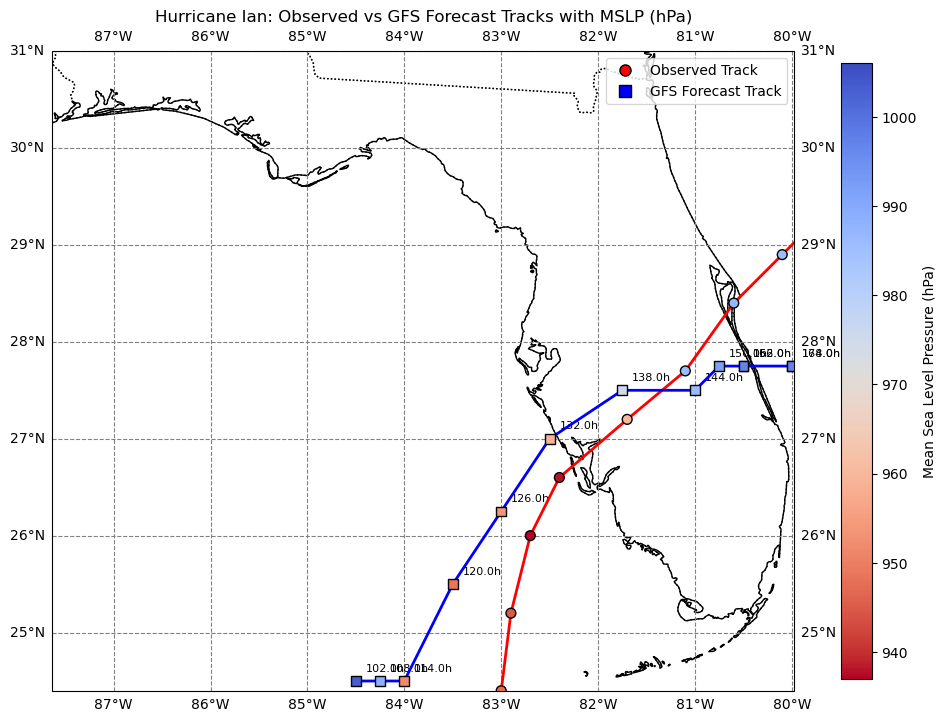

In [26]:
# GFS forecast setup
forecast_run_date = dt.datetime(2022, 9, 23, 0)
gfs_points = []

for fxx in range(102, 180, 6):
    try:
        H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=fxx)
        H.download()
        ds = H.xarray("PRMSL:mean sea level")
        ds = ds[0] if isinstance(ds, list) else ds

        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

        ds_fl = ds.sel(
            latitude=slice(florida_bounds['lat_max'], florida_bounds['lat_min']),
            longitude=slice(florida_bounds['lon_min'], florida_bounds['lon_max'])
        )

        min_pressure_flat_idx = ds_fl['prmsl'].argmin().values.item()
        min_idx = np.unravel_index(min_pressure_flat_idx, ds_fl['prmsl'].shape)

        storm_lat = ds_fl.latitude.values[min_idx[0]]
        storm_lon = ds_fl.longitude.values[min_idx[1]]
        storm_mslp = ds_fl['prmsl'].values[min_idx] / 100.0  # convert Pa to hPa

        gfs_points.append({
            "fxx": fxx,
            "latitude": storm_lat,
            "longitude": storm_lon,
            "mslp": storm_mslp
        })

    except Exception as e:
        print(f"Failed at fxx={fxx}: {e}")

# Convert GFS track to DataFrame
df_gfs = pd.DataFrame(gfs_points)

# Set up map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([florida_bounds['lon_min'], florida_bounds['lon_max'], florida_bounds['lat_min'], florida_bounds['lat_max']])

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray')

# Set up common color scale for MSLP
cmap = cm.coolwarm_r
norm = mcolors.Normalize(vmin=min(obs_slp.min(), df_gfs['mslp'].min()), vmax=max(obs_slp.max(), df_gfs['mslp'].max()))

# Plot observed track with MSLP-colored dots
sc_obs = ax.scatter(
    obs_lons, obs_lats, c=obs_slp,
    cmap=cmap, norm=norm,
    s=50, edgecolors='black', label='Observed Track', zorder=10
)

# Plot lines connecting observed track points
ax.plot(obs_lons, obs_lats, color='red', linewidth=2, linestyle='-', zorder=9)

# Plot GFS track with MSLP-colored dots
sc_gfs = ax.scatter(
    df_gfs['longitude'], df_gfs['latitude'],
    c=df_gfs['mslp'], cmap=cmap, norm=norm,
    s=50, marker='s', edgecolors='black', label='GFS Forecast Track', zorder=10
)

# Plot lines connecting GFS track points
ax.plot(df_gfs['longitude'], df_gfs['latitude'], color='blue', linewidth=2, linestyle='-', zorder=9)

# Annotate GFS points with forecast hour
for i, row in df_gfs.iterrows():
    ax.text(row['longitude'] + 0.1, row['latitude'] + 0.1, f"{row['fxx']}h", fontsize=8)

# Colorbar
cbar = plt.colorbar(sc_gfs, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Mean Sea Level Pressure (hPa)')

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Observed Track',
           markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='GFS Forecast Track',
           markerfacecolor='blue', markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, loc='upper right')

# Title
ax.set_title("Hurricane Ian: Observed vs GFS Forecast Tracks with MSLP (hPa)")

plt.tight_layout()
plt.show()

## Step 6

This code creates a time-series comparison of Hurricane Ian's observed and GFS-forecasted latitude and longitude positions. It first ensures that all time values are properly formatted as datetimes. Then, if GFS storm data is available, it generates two plots: one showing how the storm’s latitude changed over time and another for longitude. Observed and forecasted positions are plotted together, making it easy to visually assess how accurately the GFS model predicted the storm’s track over time. Each axis is labeled and formatted for clarity, with dates shown on the x-axis and a legend to distinguish observed vs. forecast data. We can see from the graphs that the GFS overall did a pretty good job of predicting the latitude and longitude of the storm, with slightly overestimating and underestimating at certain time steps compared to the actual latitude and longitude of the storm.

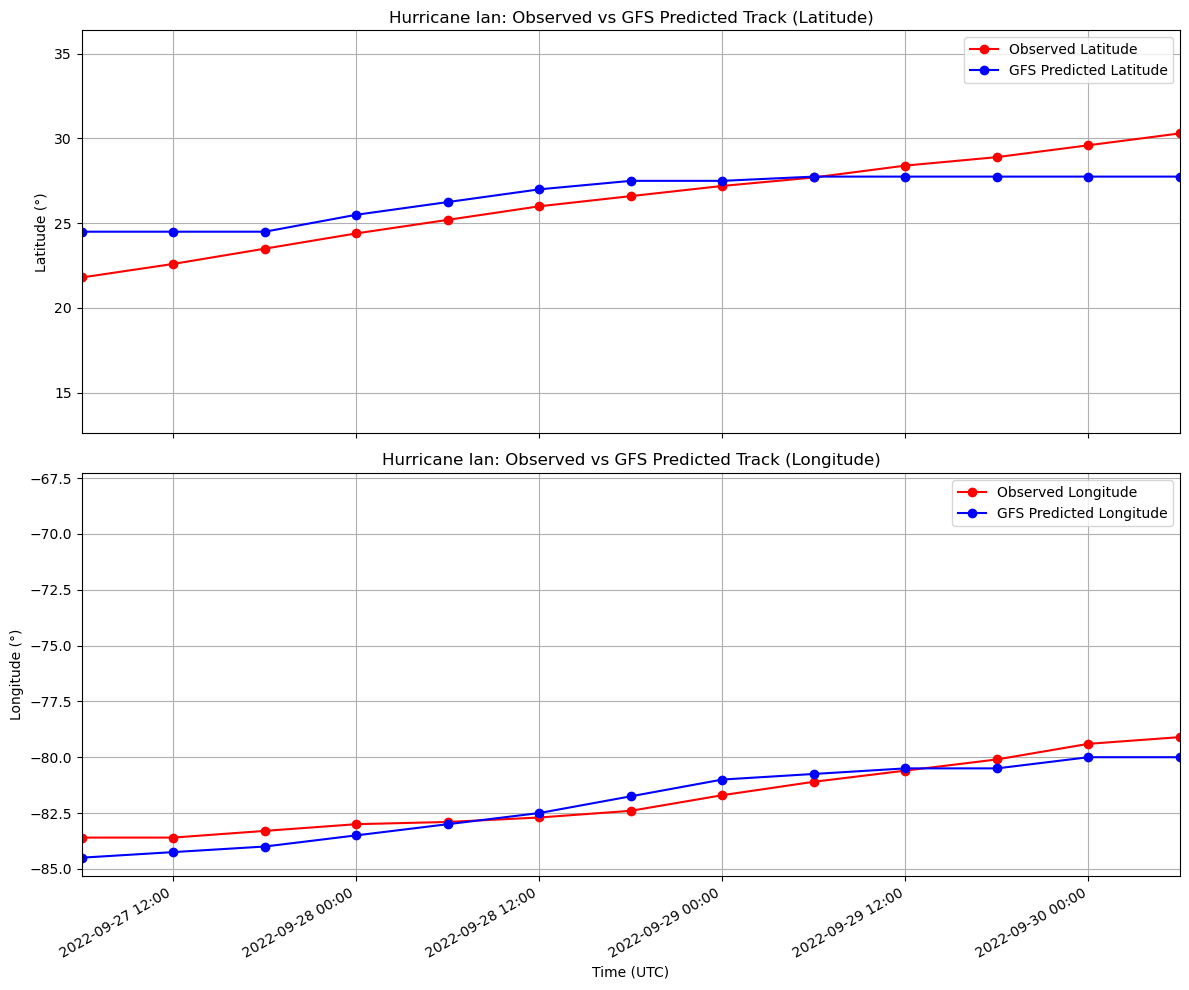

In [27]:
# Ensure datetime formatting
df_storm['valid_time'] = pd.to_datetime(df_storm['valid_time'])
obs_times = pd.to_datetime(obs_times)  # in case it's not already

# Create the time-series graph comparing latitude and longitude over time
if not df_storm.empty:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Latitude comparison
    axes[0].plot(obs_times, obs_lats, 'o-', color='red', label='Observed Latitude')
    axes[0].plot(df_storm['valid_time'], df_storm['latitude'], 'o-', color='blue', label='GFS Predicted Latitude')
    axes[0].set_ylabel('Latitude (°)')
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title('Hurricane Ian: Observed vs GFS Predicted Track (Latitude)')

    # Longitude comparison
    axes[1].plot(obs_times, obs_lons, 'o-', color='red', label='Observed Longitude')
    axes[1].plot(df_storm['valid_time'], df_storm['longitude'], 'o-', color='blue', label='GFS Predicted Longitude')
    axes[1].set_ylabel('Longitude (°)')
    axes[1].set_xlabel('Time (UTC)')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title('Hurricane Ian: Observed vs GFS Predicted Track (Longitude)')

    # Set the date formatter for the x-axis
    date_format = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[1].xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()

    # Adjust the x-axis limits to focus on the relevant dates
    plt.xlim(min(df_storm['valid_time']), max(df_storm['valid_time']))

    plt.tight_layout()
    plt.show()
else:
    print("No storm points found.")


## Step 7

This code compares the predicted intensity of Hurricane Ian from the GFS forecast model to observed intensity values over time. It loops through several forecast hours, downloading GFS data using the Herbie package and identifying the storm center by locating the minimum mean sea level pressure (MSLP) at each timestep. A simplified formula converts this pressure to an estimated wind intensity in knots. The predicted intensities and times are stored, then plotted alongside observed values in a time-series graph. This visual comparison helps assess how well the GFS model captured the storm's strength throughout its life cycle. We can see from the graph that the GFS overestimated the intensity of Hurricane Ian by quite a bit except for Sept 28, which is right around when the storm made landfall in SW Florida, where the observed intensity was over 130 kts compared the GFS which predicted slightly below that.

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F06 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F12 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F18 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F24 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F30 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F36 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F42 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F48 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F54 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F60 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=

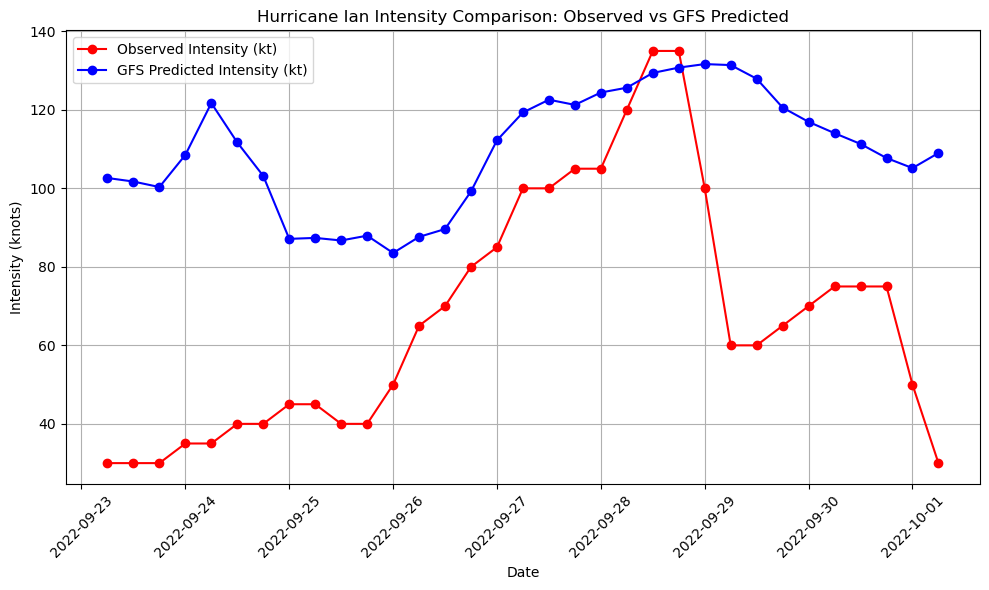

In [28]:
# Define forecast model run date and initialize Herbie for GFS data
forecast_run_date = dt.datetime(2022, 9, 23, 0) 
gfs_intensity = []
gfs_times = []

# Loop through multiple forecast hours
for fxx in range(6, 200, 6): 
    try:
        H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=fxx)
        H.download()  # Ensure GRIB2 file is downloaded
        
        # Load data using Herbie's xarray method for PRMSL (Mean Sea Level Pressure)
        ds = H.xarray("PRMSL:mean sea level")
        
        # Adjust longitudes to [-180, 180] for compatibility with Florida's bounds
        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
        
        # Extract storm center (minimum pressure) for the current time step
        min_pressure_flat_idx = ds['prmsl'].argmin().values.item()
        min_pressure_idx = np.unravel_index(min_pressure_flat_idx, ds['prmsl'].shape)
        
        storm_lat = ds.latitude.values[min_pressure_idx[0]]
        storm_lon = ds.longitude.values[min_pressure_idx[1]]
        
        # Calculate predicted intensity from minimum pressure
        min_pressure_hpa = ds['prmsl'].values[min_pressure_idx] / 100.0  # Convert Pa to hPa
        predicted_intensity_knots = max(0, (1013 - min_pressure_hpa) * 1.5)  # Simplified formula
        
        # Append predicted intensity and valid time to lists
        gfs_intensity.append(predicted_intensity_knots)
        gfs_times.append(ds.valid_time.values)

    except Exception as e:
        print(f"Error processing GFS data for fxx={fxx}: {e}")
        continue

# Convert GFS times to pandas datetime
gfs_times = pd.to_datetime(gfs_times)

# Plot Intensity Comparison
plt.figure(figsize=(10, 6))
plt.plot(obs_times, obs_intensity, 'o-', label="Observed Intensity (kt)", color='red')
plt.plot(gfs_times, gfs_intensity, 'o-', label="GFS Predicted Intensity (kt)", color='blue')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Intensity (knots)")
plt.title("Hurricane Ian Intensity Comparison: Observed vs GFS Predicted")
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

## Step 8

This code generates a detailed visualization of Hurricane Ian by overlaying observed storm track data with GFS model output for wind speed, wind vectors, and sea level pressure. It begins by constructing datetime objects from the observed dataset and standardizing longitudes to match the GFS forecast grid. After downloading GFS data using Herbie, it selects a spatial subset around the storm’s track and calculates wind speed and pressure fields. The code then creates a map using `cartopy`, displaying GFS wind speeds as a colored mesh, wind vectors as arrows, and pressure as contours. Observed storm positions are plotted and colored by intensity, enabling a comprehensive comparison between observations and model predictions. We can see from the map that the GFS wind speeds and directions follow the pressure contours and become stronger as they get closer to the storms center.

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-28 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


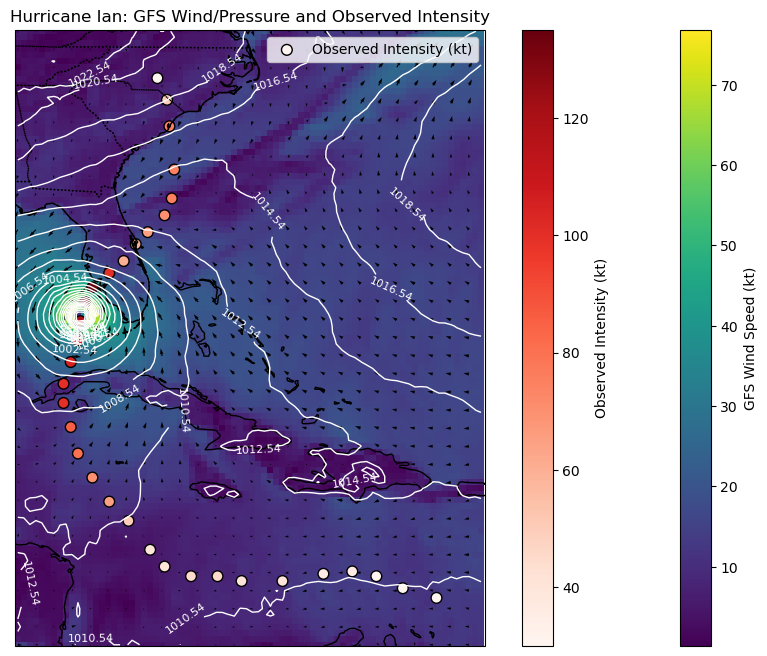

In [29]:
# Create datetime from parts
observed_track['MONTH'] = observed_track['MONTH'].astype(str).str.zfill(2)
observed_track['DAY'] = observed_track['DAY'].astype(str).str.zfill(2)
observed_track['HHMM'] = observed_track['HHMM'].astype(str).str.zfill(4)
observed_track['DTG'] = pd.to_datetime(
    observed_track['YEAR'].astype(str) + '-' +
    observed_track['MONTH'] + '-' +
    observed_track['DAY'] + ' ' +
    observed_track['HHMM'].str[:2] + ':' +
    observed_track['HHMM'].str[2:],
    format='%Y-%m-%d %H:%M'
)

# Normalize longitudes from [0, 360] to [-180, 180]
obs_lats = observed_track['LAT']
obs_lons = ((observed_track['LON'] + 180) % 360) - 180
obs_pressure = observed_track['MSLP']
obs_intensity = observed_track['INTENSITY']

# Load GFS forecast
forecast_run_date = pd.Timestamp("2022-09-28 00:00:00")
fxx = 6
H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=fxx)

# Load U, V, and PRMSL
ds_u = H.xarray("UGRD:10 m above ground")
ds_v = H.xarray("VGRD:10 m above ground")
ds_p = H.xarray("PRMSL:mean sea level")

# Fix longitude for all datasets
def fix_lon(ds):
    ds = ds.rename({'lon': 'longitude'}) if 'lon' in ds.coords else ds
    ds['longitude'] = (((ds['longitude'] + 180) % 360) - 180)
    ds = ds.sortby('longitude')
    return ds

ds_u = fix_lon(ds_u)
ds_v = fix_lon(ds_v)
ds_p = fix_lon(ds_p)

# Subset lat/lon based on obs track
lat_min, lat_max = obs_lats.min() - 2, obs_lats.max() + 2
lon_min, lon_max = obs_lons.min() - 2, obs_lons.max() + 2

ds_u = ds_u.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
ds_v = ds_v.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
ds_p = ds_p.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Ensure shapes are valid
U = ds_u['u10'].values
V = ds_v['v10'].values
if U.shape[1] == 0 or V.shape[1] == 0:
    raise ValueError("Empty subset returned! Check longitude/latitude bounds.")

wind_speed = np.sqrt(U**2 + V**2)
lons = ds_u.longitude.values
lats = ds_u.latitude.values
LON, LAT = np.meshgrid(lons, lats)

pressure_hpa = ds_p['prmsl'].values / 100.0

# Convert wind speed from m/s to knots (1 m/s = 1.94384 knots)
wind_speed_knots = wind_speed * 1.94384

# Plotting
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

# Plot GFS wind speed as a color mesh in knots
pcm = ax.pcolormesh(LON, LAT, wind_speed_knots, cmap='viridis', shading='auto')
plt.colorbar(pcm, ax=ax, orientation='vertical', label='GFS Wind Speed (kt)')

# Plot GFS wind vectors (quiver plot)
skip = (slice(None, None, 3), slice(None, None, 3))  # Skip every third point for clarity
ax.quiver(LON[skip], LAT[skip], U[skip], V[skip], scale=700, width=0.0025)

# Plot GFS pressure contours
contours = ax.contour(LON, LAT, pressure_hpa, colors='white', linewidths=1.0,
                      levels=np.arange(np.nanmin(pressure_hpa), np.nanmax(pressure_hpa), 2))
ax.clabel(contours, inline=True, fontsize=8)

# Overlay observed points colored by intensity (knots)
sc_obs = ax.scatter(obs_lons, obs_lats, c=obs_intensity,
                    cmap='Reds', edgecolor='black', s=60,
                    label='Observed Intensity (kt)', transform=ccrs.PlateCarree())
plt.colorbar(sc_obs, ax=ax, orientation='vertical', label='Observed Intensity (kt)')

ax.set_title("Hurricane Ian: GFS Wind/Pressure and Observed Intensity")
ax.legend()
plt.show()


## Step 9

This code compares the observed and GEFS forecasted tracks of Hurricane Ian over Florida, focusing on mean sea level pressure (MSLP). It loops through multiple GEFS forecast hours, downloading the relevant data for each, adjusting longitudes, and extracting the storm's location and MSLP. The code then creates a plot showing the observed storm track with colored dots representing MSLP and the GEFS forecast track with similar MSLP coloring. The map highlights both tracks, adds a colorbar for MSLP, and labels the forecast hours, providing a clear visual comparison of observed vs. forecasted storm paths. We can see that the GEFS was actually closer to the actual track of the storm compared to the GFS, particularly more accurately predicting the landfall location of the storm.

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F96 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F102 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F108 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F114 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F120 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F126 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F132 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F138 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F144 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F150 ┊ GRIB2 @ local ┊ IDX @ aws


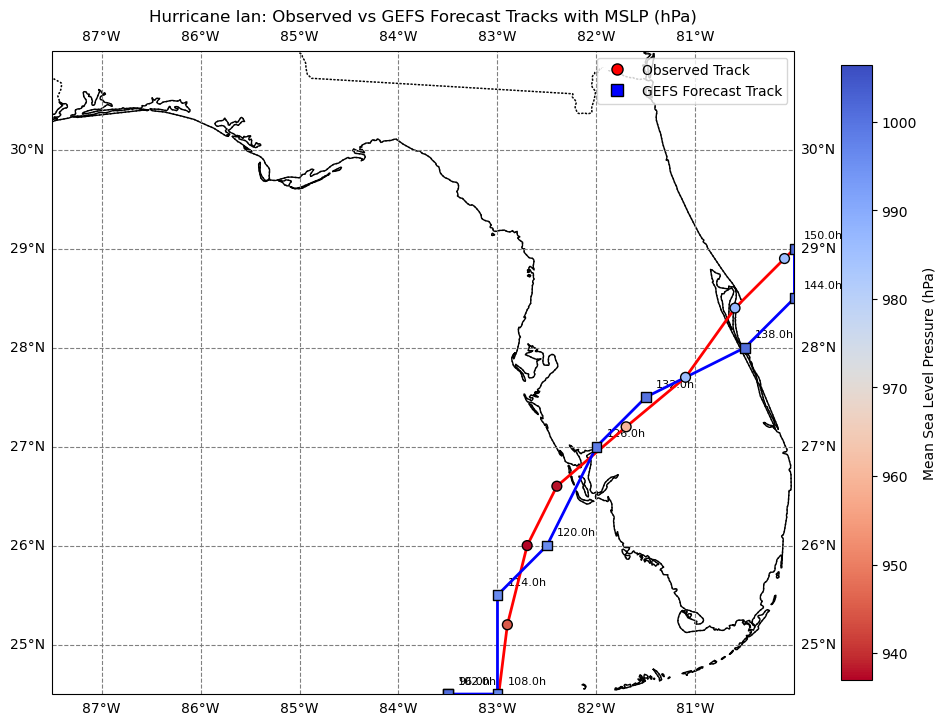

In [30]:
# Florida region bounds
florida_bounds = {
    'lat_min': 24.5,
    'lat_max': 31.0,
    'lon_min': -87.5,
    'lon_max': -80.0
}

# GEFS forecast setup
forecast_run_date = dt.datetime(2022, 9, 23, 0)
gefs_points = []

for fxx in range(96, 156, 6):
    try:
        H = Herbie(forecast_run_date, model="gefs", product="atmos.5", member="c00", fxx=fxx)
        H.download()
        ds = H.xarray("PRMSL:mean sea level")
        ds = ds[0] if isinstance(ds, list) else ds

        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

        ds_fl = ds.sel(
            latitude=slice(florida_bounds['lat_max'], florida_bounds['lat_min']),
            longitude=slice(florida_bounds['lon_min'], florida_bounds['lon_max'])
        )

        min_pressure_flat_idx = ds_fl['prmsl'].argmin().values.item()
        min_idx = np.unravel_index(min_pressure_flat_idx, ds_fl['prmsl'].shape)

        storm_lat = ds_fl.latitude.values[min_idx[0]]
        storm_lon = ds_fl.longitude.values[min_idx[1]]
        storm_mslp = ds_fl['prmsl'].values[min_idx] / 100.0  # convert Pa to hPa

        gefs_points.append({
            "fxx": fxx,
            "latitude": storm_lat,
            "longitude": storm_lon,
            "mslp": storm_mslp
        })

    except Exception as e:
        print(f"Failed at fxx={fxx}: {e}")

# Convert GEFS track to DataFrame
df_gefs = pd.DataFrame(gefs_points)

# Set up map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([florida_bounds['lon_min'], florida_bounds['lon_max'], florida_bounds['lat_min'], florida_bounds['lat_max']])

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray')

# Set up common color scale for MSLP
cmap = cm.coolwarm_r
norm = mcolors.Normalize(vmin=min(obs_slp.min(), df_gefs['mslp'].min()), vmax=max(obs_slp.max(), df_gefs['mslp'].max()))

# Plot observed track with MSLP-colored dots
sc_obs = ax.scatter(
    obs_lons, obs_lats, c=obs_slp,
    cmap=cmap, norm=norm,
    s=50, edgecolors='black', label='Observed Track', zorder=10
)

# Plot lines connecting observed track points
ax.plot(obs_lons, obs_lats, color='red', linewidth=2, linestyle='-', zorder=9)

# Plot GEFS track with MSLP-colored dots
sc_gefs = ax.scatter(
    df_gefs['longitude'], df_gefs['latitude'],
    c=df_gefs['mslp'], cmap=cmap, norm=norm,
    s=50, marker='s', edgecolors='black', label='GEFS Forecast Track', zorder=10
)

# Plot lines connecting GEFS track points
ax.plot(df_gefs['longitude'], df_gefs['latitude'], color='blue', linewidth=2, linestyle='-', zorder=9)

# Annotate GEFS points with forecast hour
for i, row in df_gefs.iterrows():
    ax.text(row['longitude'] + 0.1, row['latitude'] + 0.1, f"{row['fxx']}h", fontsize=8)

# Colorbar
cbar = plt.colorbar(sc_gefs, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Mean Sea Level Pressure (hPa)')

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Observed Track',
           markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='GEFS Forecast Track',
           markerfacecolor='blue', markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, loc='upper right')

# Title
ax.set_title("Hurricane Ian: Observed vs GEFS Forecast Tracks with MSLP (hPa)")

plt.tight_layout()
plt.show()


## Step 10

This code compares the observed and GFS forecasted storm centers of Hurricane Ian, focusing on pressure data. It extracts the necessary columns (latitude, longitude, pressure) from the observed track, initializes the Herbie package to retrieve GFS data for mean sea level pressure (PRMSL), and subsets the GFS data around the storm's location. The code then visualizes the observed storm center with a scatter plot, colored by pressure, and creates a second plot showing the GFS predicted storm center with pressure contours and a filled color map. The results are displayed with annotations for both the observed and predicted storm centers, helping to visually assess the accuracy of the GFS forecast. We can see clearly that the GFS predicted the storm to make landfall with an MSLP of approximately 960 mb, compared to the actual track with an MSLP of approximately 940 mb.

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-28 12:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


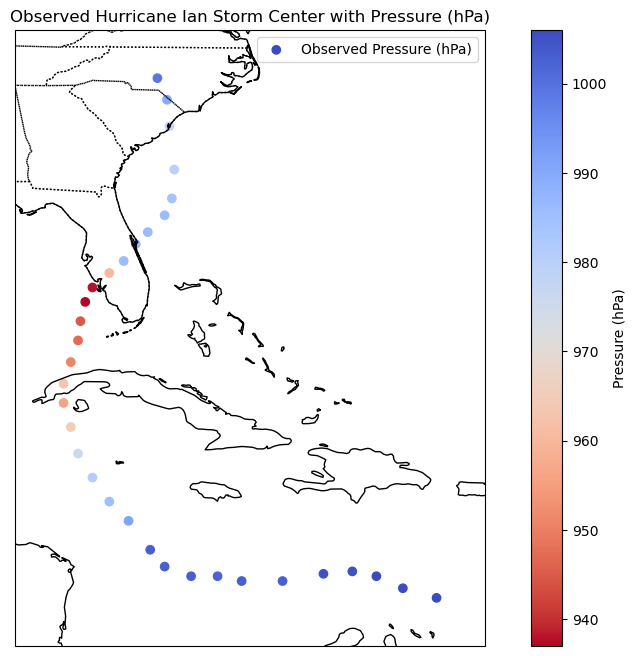

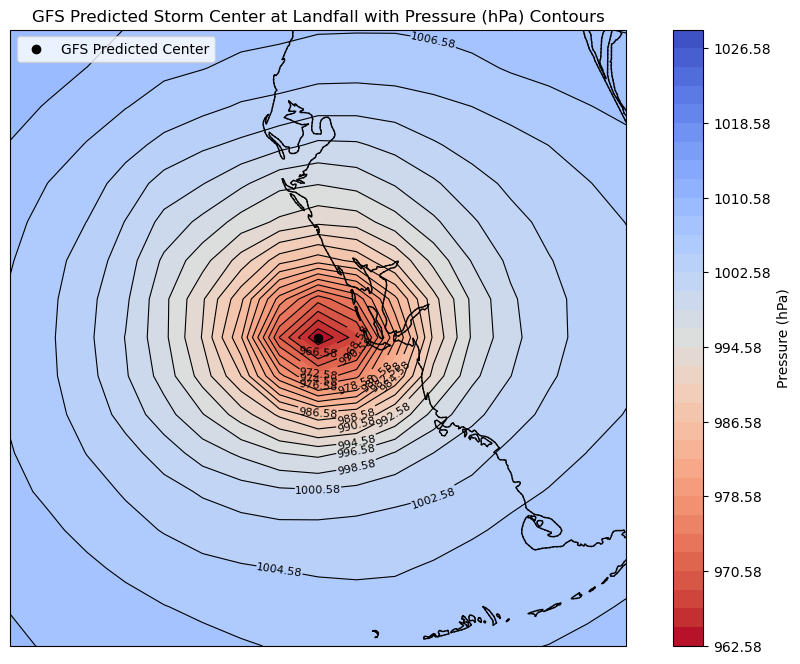

In [31]:
# Extract necessary columns: latitude, longitude, and pressure
obs_lats = observed_track['LAT']
obs_lons = observed_track['LON']
obs_pressure = observed_track['MSLP'] 

# Define forecast model run date and initialize Herbie for GFS data
forecast_run_date = pd.Timestamp("2022-09-28 12:00:00")
H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=6)

# Load GFS data for PRMSL (Pressure Reduced to Mean Sea Level)
ds = H.xarray("PRMSL:mean sea level")

# Adjust longitudes to [-180, 180] for compatibility with Cartopy
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

# Subset GFS data to focus on the region around the storm
region_bounds = {
    'lat_min': obs_lats.min() - 5,
    'lat_max': obs_lats.max() + 5,
    'lon_min': obs_lons.min() - 5,
    'lon_max': obs_lons.max() + 5,
}
gfs_subset = ds.sel(
    latitude=slice(region_bounds['lat_max'], region_bounds['lat_min']),
    longitude=slice(region_bounds['lon_min'], region_bounds['lon_max'])
)

# Convert PRMSL from Pa to hPa for visualization
gfs_pressure_hpa = gfs_subset['prmsl'] / 100.0

# Find storm center in GFS (minimum pressure)
min_pressure_idx = np.unravel_index(np.argmin(gfs_pressure_hpa.values), gfs_pressure_hpa.shape)
storm_lat_gfs = gfs_pressure_hpa.latitude.values[min_pressure_idx[0]]
storm_lon_gfs = gfs_pressure_hpa.longitude.values[min_pressure_idx[1]]

# Plot Observed Data Map with Scatter Plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
ax.set_extent([obs_lons.min() - 2, obs_lons.max() + 2, obs_lats.min() - 2, obs_lats.max() + 2], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
sc_obs = ax.scatter(
    obs_lons,
    obs_lats,
    c=obs_pressure,
    cmap='coolwarm_r',  # Reverse colormap (warmer colors for lower pressure)
    label="Observed Pressure (hPa)",
    transform=ccrs.PlateCarree()
)
plt.colorbar(sc_obs, ax=ax, orientation='vertical', label="Pressure (hPa)")
ax.set_title("Observed Hurricane Ian Storm Center with Pressure (hPa)")


plt.legend()

# Plot GFS Data Map with Contourf and Contour Lines
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
ax.set_extent([storm_lon_gfs - 2, storm_lon_gfs + 2, storm_lat_gfs - 2, storm_lat_gfs + 2], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

# Filled contours for GFS pressure data
contourf_gfs = ax.contourf(
    gfs_pressure_hpa.longitude,
    gfs_pressure_hpa.latitude,
    gfs_pressure_hpa.values,
    levels=np.arange(gfs_pressure_hpa.min(), gfs_pressure_hpa.max(), 2),
    cmap='coolwarm_r',  # Reverse colormap (warmer colors for lower pressure)
    transform=ccrs.PlateCarree()
)

# Add a colorbar for the filled contours
plt.colorbar(contourf_gfs, ax=ax, orientation='vertical', label="Pressure (hPa)")

# Line contours for GFS pressure data
contour_lines_gfs = ax.contour(
    gfs_pressure_hpa.longitude,
    gfs_pressure_hpa.latitude,
    gfs_pressure_hpa.values,
    levels=np.arange(gfs_pressure_hpa.min(), gfs_pressure_hpa.max(), 2),
    colors='black',  # Black contour lines
    linewidths=0.8,
    transform=ccrs.PlateCarree()
)

# Add labels to the contour lines
ax.clabel(contour_lines_gfs, inline=True, fontsize=8)

# Mark the predicted storm center
ax.scatter(storm_lon_gfs, storm_lat_gfs, color='black', label="GFS Predicted Center", transform=ccrs.PlateCarree())

# Add title and legend
ax.set_title("GFS Predicted Storm Center at Landfall with Pressure (hPa) Contours")
plt.legend()

plt.show()


## Step 11

This code compares the observed and GEFS forecasted storm centers of Hurricane Ian, focusing on pressure data from the GEFS ensemble. It first loads the observed track data and converts the DTG (Date-Time Group) column to datetime format. After extracting the necessary columns (latitude, longitude, and pressure), it initializes the Herbie package to retrieve GEFS data for mean sea level pressure (PRMSL). The data is adjusted for longitude and subsetted to focus on the region around the storm. The code then finds the storm center based on the minimum pressure for both observed and GEFS data. 

Like Step 10, the first visualization shows the observed storm center with a scatter plot of pressure values. The second visualization displays the GEFS forecasted storm center with contour plots of the pressure field, including the filled contours for all ensemble members (with transparency) and contour lines for the pressure data. The storm center is marked, allowing for a visual comparison between the observed and GEFS-predicted storm locations, as well as the uncertainty in the forecast due to the ensemble members.

We can see that the GEFS seemingly underestimated the strength of the storm at landfall with only a minimum pressure of approximately 995 mb at landfall compared to the observed data that had the storm's minimum pressure at landfall of about 940 mb.

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-28 12:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


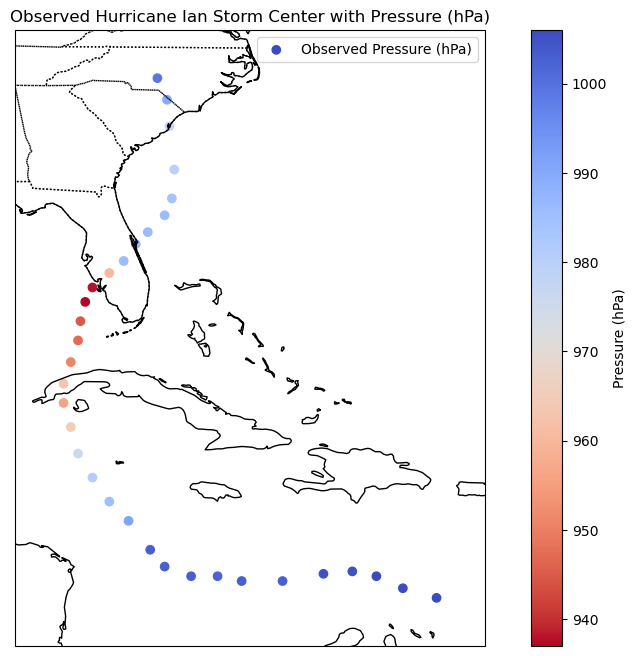

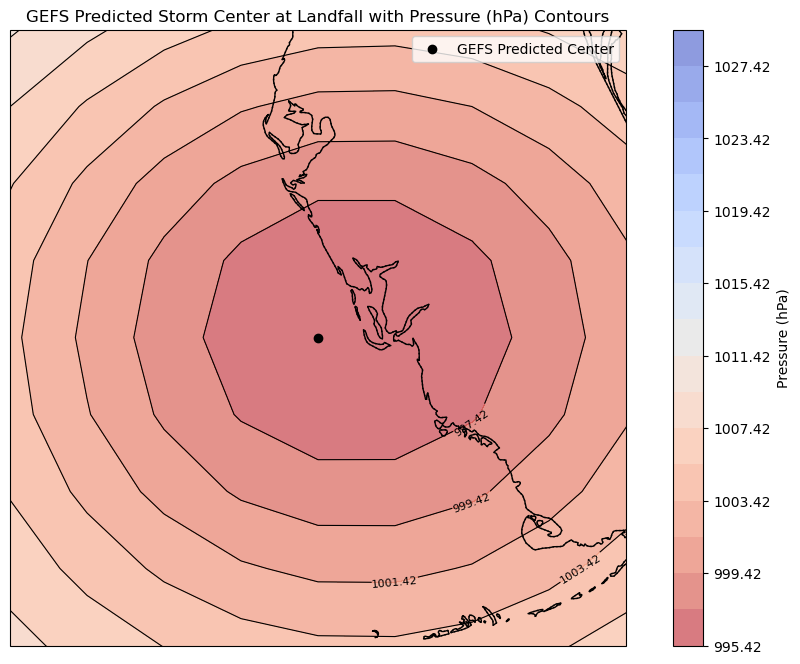

In [34]:
# Extract necessary columns: latitude, longitude, and pressure
obs_lats = observed_track['LAT']
obs_lons = observed_track['LON']
obs_pressure = observed_track['MSLP']

# Define forecast model run date and initialize Herbie for GEFS data
forecast_run_date = pd.Timestamp("2022-09-28 12:00:00")
H = Herbie(forecast_run_date, model="gefs", product="atmos.5", member="c00", fxx=6)

# Load GEFS data for PRMSL (Pressure Reduced to Mean Sea Level)
ds = H.xarray("PRMSL:mean sea level")

# Adjust longitudes to [-180, 180] for compatibility with Cartopy
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

# Subset GEFS data to focus on the region around the storm
region_bounds = {
    'lat_min': obs_lats.min() - 5,
    'lat_max': obs_lats.max() + 5,
    'lon_min': obs_lons.min() - 5,
    'lon_max': obs_lons.max() + 5,
}
gefs_subset = ds.sel(
    latitude=slice(region_bounds['lat_max'], region_bounds['lat_min']),
    longitude=slice(region_bounds['lon_min'], region_bounds['lon_max'])
)

# Convert PRMSL from Pa to hPa for visualization
gefs_pressure_hpa = gefs_subset['prmsl'] / 100.0

# Find storm center in GEFS (minimum pressure)
min_pressure_idx = np.unravel_index(np.argmin(gefs_pressure_hpa.values), gefs_pressure_hpa.shape)
storm_lat_gefs = gefs_pressure_hpa.latitude.values[min_pressure_idx[0]]
storm_lon_gefs = gefs_pressure_hpa.longitude.values[min_pressure_idx[1]]

# Plot Observed Data Map with Scatter Plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
ax.set_extent([obs_lons.min() - 2, obs_lons.max() + 2, obs_lats.min() - 2, obs_lats.max() + 2], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
sc_obs = ax.scatter(
    obs_lons,
    obs_lats,
    c=obs_pressure,
    cmap='coolwarm_r',  # Reverse colormap (warmer colors for lower pressure)
    label="Observed Pressure (hPa)",
    transform=ccrs.PlateCarree()
)
plt.colorbar(sc_obs, ax=ax, orientation='vertical', label="Pressure (hPa)")
ax.set_title("Observed Hurricane Ian Storm Center with Pressure (hPa)")

plt.legend()

# Plot GEFS Data Map with Contourf and Contour Lines
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
ax.set_extent([storm_lon_gefs - 2, storm_lon_gefs + 2, storm_lat_gefs - 2, storm_lat_gefs + 2], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

# Find storm center in GEFS (minimum pressure)
min_pressure_idx = np.unravel_index(np.argmin(gefs_pressure_hpa.values), gefs_pressure_hpa.shape)
storm_lat_gefs = gefs_pressure_hpa.latitude.values[min_pressure_idx[0]]
storm_lon_gefs = gefs_pressure_hpa.longitude.values[min_pressure_idx[1]]

# Loop over ensemble members to plot GEFS forecast
# Check if the GEFS data has an ensemble dimension or if it's just 2D (time vs lat/lon)
if len(gefs_pressure_hpa.shape) == 3:
    # If 3D (ensemble, latitude, longitude), loop through ensemble members
    for member in range(gefs_pressure_hpa.shape[0]):  # Looping through ensemble members
        
        # Filled contours for GEFS pressure data (assuming the data is 2D)
        contourf_gefs = ax.contourf(
            gefs_pressure_hpa.longitude,
            gefs_pressure_hpa.latitude,
            gefs_pressure_hpa.values[member, :, :],  # Select data for the current ensemble member
            levels=np.arange(gefs_pressure_hpa.min(), gefs_pressure_hpa.max(), 2),
            cmap='coolwarm_r',  # Reverse colormap (warmer colors for lower pressure)
            alpha=0.6,  # Transparency for ensemble members
            transform=ccrs.PlateCarree()
        )
else:
    # If the data is 2D (time vs lat/lon), we don't have ensemble members
    contourf_gefs = ax.contourf(
        gefs_pressure_hpa.longitude,
        gefs_pressure_hpa.latitude,
        gefs_pressure_hpa.values,  # Plot without looping over ensemble
        levels=np.arange(gefs_pressure_hpa.min(), gefs_pressure_hpa.max(), 2),
        cmap='coolwarm_r',  # Reverse colormap (warmer colors for lower pressure)
        alpha=0.6,  # Transparency for ensemble members
        transform=ccrs.PlateCarree()
    )

# Add a colorbar for the filled contours
plt.colorbar(contourf_gefs, ax=ax, orientation='vertical', label="Pressure (hPa)")

# Line contours for GEFS pressure data
if len(gefs_pressure_hpa.shape) == 3:
    contour_lines_gefs = ax.contour(
        gefs_pressure_hpa.longitude,
        gefs_pressure_hpa.latitude,
        gefs_pressure_hpa.values[0, :, :],  # Select data for the first ensemble member
        levels=np.arange(gefs_pressure_hpa.min(), gefs_pressure_hpa.max(), 2),
        colors='black',  # Black contour lines
        linewidths=0.8,
        transform=ccrs.PlateCarree()
    )
else:
    contour_lines_gefs = ax.contour(
        gefs_pressure_hpa.longitude,
        gefs_pressure_hpa.latitude,
        gefs_pressure_hpa.values,  # Plot for the 2D data
        levels=np.arange(gefs_pressure_hpa.min(), gefs_pressure_hpa.max(), 2),
        colors='black',  # Black contour lines
        linewidths=0.8,
        transform=ccrs.PlateCarree()
    )

# Add labels to the contour lines
ax.clabel(contour_lines_gefs, inline=True, fontsize=8)

# Mark the predicted storm center (using the first ensemble member)
ax.scatter(storm_lon_gefs, storm_lat_gefs, color='black', label="GEFS Predicted Center", transform=ccrs.PlateCarree())

# Add title and legend
ax.set_title("GEFS Predicted Storm Center at Landfall with Pressure (hPa) Contours")
plt.legend()

plt.show()
